# Part one - week one


## Description of the problem
In this problem i am going to solve a localization problem for a restaurant. One of the key factor for opening a business is to have answer to the question WHERE. In cities there are many naighborhoods and in that neighbors different people belonging to different economic lines lives. If an investor has an idea of a product, it is important to put the restaurant in a place where people will understand and apreciate the value of the product. Anybody can have a great product to sell, but you have to be in the right place to sell it even to give a great customer service.
This project will be executed in the city of santa cruz de la sierra, Bolivia.

## Description fo the data
The data will be, reviews, quantity of restaurants, type of food they eat, density of people in the section, 
A description of how the data will be used to solve de problem and where the data is

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import folium, json,requests, googlemaps, pprint, time
from geopy.geocoders import Nominatim
from sklearn import preprocessing
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

In [2]:
# Defining useful functions
def get_venue_category_type(row):
    try:
        category_list = row["categories"]
    except:
        category_list = row["venue.categories"]
    if len(category_list) == 0:
        return None
    else:
        return category_list[0]["name"]

In [3]:
#getting location for the center point of the city
address = "Plaza 24 de Septiembre, Santa Cruz, Bolivia"
geolocator = Nominatim(user_agent="foursquare_agent")
geocode = geolocator.geocode(address)
print("Latitude is: ",geocode.latitude, "longitude is:",geocode.longitude)

Latitude is:  -17.78329515 longitude is: -63.182114510279575


In [4]:
#params for foursquare
client_id=""
client_secret=""
v="20191206"
radius = 4000
search_query = "food"
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}'.format(client_id, client_secret, geocode.latitude, geocode.longitude, v, search_query, radius)


In [5]:
results = requests.get(url).json()
pprint.pprint(results)

ng'},
                                          'id': '4bf58dd8d48988d16c941735',
                                          'name': 'Burger Joint',
                                          'pluralName': 'Burger Joints',
                                          'primary': True,
                                          'shortName': 'Burgers'}],
                          'hasPerk': False,
                          'id': '508dc940e4b055a759175128',
                          'location': {'address': 'Avenida Mutualista',
                                       'cc': 'BO',
                                       'city': 'Santa Cruz de la Sierra',
                                       'country': 'Bolivia',
                                       'distance': 1941,
                                       'formattedAddress': ['Avenida '
                                                            'Mutualista',
                                                            'Santa Cruz de la '
        

In [6]:
venues = pd.io.json.json_normalize(results["response"]["venues"])
# filtering useful columns
venues = venues.loc[slice(None), ["name", "categories"] + [col for col in venues.columns if col.startswith("location.")] + ["id"]]
venues["categories"] = venues.apply(get_venue_category_type, axis=1)
print(venues.columns)

Index(['name', 'categories', 'location.lat', 'location.lng',
       'location.labeledLatLngs', 'location.distance', 'location.cc',
       'location.state', 'location.country', 'location.formattedAddress',
       'location.city', 'location.address', 'location.crossStreet', 'id'],
      dtype='object')


In [7]:
#getting information about venues dataframe
print("venues df shape is: ",venues.shape, "\n")
print(venues.info(), "\n")
for i in venues.columns.values:
    print(i)
    print(venues[i].value_counts(),"\n")
print(venues.isnull().sum(), "\n")

venues df shape is:  (30, 14) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       30 non-null     object 
 1   categories                 29 non-null     object 
 2   location.lat               30 non-null     float64
 3   location.lng               30 non-null     float64
 4   location.labeledLatLngs    30 non-null     object 
 5   location.distance          30 non-null     int64  
 6   location.cc                30 non-null     object 
 7   location.state             26 non-null     object 
 8   location.country           30 non-null     object 
 9   location.formattedAddress  30 non-null     object 
 10  location.city              25 non-null     object 
 11  location.address           13 non-null     object 
 12  location.crossStreet       4 non-null      object 
 13  id                  

In [8]:
# Deleting useless columns
venues.drop(columns=["location.address", "location.crossStreet", "location.cc"], inplace=True)
# filling missing data and replacing to get more uniform data
venues["location.state"].fillna("Santa Cruz", inplace=True)
venues["location.state"].replace(to_replace=["SCZ", "Andres Ibañez"], value="Santa Cruz", inplace=True)
venues["location.city"].fillna("Santa Cruz de la Sierra", inplace=True)
venues["location.city"].replace(to_replace=["Santa Cruz", "Bolivia"], value="Santa Cruz de la Sierra", inplace=True)

In [9]:
venues

,name,categories,location.lat,location.lng,location.labeledLatLngs,location.distance,location.state,location.country,location.formattedAddress,location.city,id
0,Las Vegas Buffet Fast Food,Buffet,-17.773001,-63.194445,"[{'label': 'display', 'lat': -17.773001, 'lng'...",1738,Santa Cruz,Bolivia,[Bolivia],Santa Cruz de la Sierra,5d7bd58e2deabf00082c99db
1,Brazilian Fast Food,Fast Food Restaurant,-17.782999,-63.185392,"[{'label': 'display', 'lat': -17.782999, 'lng'...",348,Santa Cruz,Bolivia,"[Santa Cruz de la Sierra, Bolivia]",Santa Cruz de la Sierra,4d08be1ce554721e4f66c3f8
2,Chapaco's Fast Food Grill,BBQ Joint,-17.766326,-63.164481,"[{'label': 'display', 'lat': -17.7663256212280...",2657,Santa Cruz,Bolivia,"[Santa Cruz de la Sierra, Bolivia]",Santa Cruz de la Sierra,5349db8f498e54a3178975a3
3,"Canyella - Food, Drinks & Music",Mediterranean Restaurant,-17.782080,-63.186061,"[{'label': 'display', 'lat': -17.7820803075033...",439,Santa Cruz,Bolivia,"[Calle 21 de Mayo 258, Santa Cruz de la Sierra...",Santa Cruz de la Sierra,52b1dedd11d2564fa7a312a0
4,My Food,Fast Food Restaurant,-17.785425,-63.188457,"[{'label': 'display', 'lat': -17.7854251861572...",712,Santa Cruz,Bolivia,"[Av Cañoto, Santa Cruz de la Sierra, Bolivia]",Santa Cruz de la Sierra,55048e00498ee7519a90e643
5,Garajes Food Trucks,Food Truck,-17.755136,-63.172903,"[{'label': 'display', 'lat': -17.7551359812027...",3283,Santa Cruz,Bolivia,"[Santa Cruz de la Sierra, Bolivia]",Santa Cruz de la Sierra,5a419c6a6f0aa276862e5dfd
6,Mexican Food,Mexican Restaurant,-17.788620,-63.186354,"[{'label': 'display', 'lat': -17.7886199703056...",743,Santa Cruz,Bolivia,[Bolivia],Santa Cruz de la Sierra,4f95ecdbe4b0d1d5d4540221
7,La Estancia Fast Food,Argentinian Restaurant,-17.782375,-63.189168,"[{'label': 'display', 'lat': -17.7823749343877...",754,Santa Cruz,Bolivia,"[Santa Cruz de la Sierra, Bolivia]",Santa Cruz de la Sierra,4fc16687e4b0d516251295af
8,Mexican Food,Mexican Restaurant,-17.788543,-63.186412,"[{'label': 'display', 'lat': -17.7885434367881...",740,Santa Cruz,Bolivia,"[Av. Los cusis #2190 (Entre Beni y Alemana), S...",Santa Cruz de la Sierra,50fb48c3e4b0d0486d09b3f3
9,Toty's Fast Food,Fast Food Restaurant,-17.774745,-63.180204,"[{'label': 'display', 'lat': -17.7747451624698...",973,Santa Cruz,Bolivia,"[Avenida Uruguay #150, Santa Cruz de la Sierr...",Santa Cruz de la Sierra,524af9f611d21590ad9a2786


In [10]:
# graphing venues
venues_map = folium.Map(location=[geocode.latitude, geocode.longitude], zoom_start=13)
tooltip = "click me!"
folium.features.Marker(location=[geocode.latitude, geocode.longitude], popup="Plaza 24 de Septiembre", icon=folium.Icon(color="red")).add_to(venues_map)
# adding the other restaurants in the map
for lat, lon, label in zip(venues["location.lat"], venues["location.lng"], venues.name):
    folium.features.Marker(location=[lat, lon], popup=label).add_to(venues_map)

venues_map
#ocation=[geocode.latitude, geocode.longitude], zoom_start=13)


In [11]:
# getting venues ratings or visits quantity
venue_id = '5d7bd58e2deabf00082c99db'
url = "https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}".format(venue_id, client_id, client_secret, v)

In [12]:
# results of venue_id
results = requests.get(url).json()
pprint.pprint(results["response"])

{'venue': {'allowMenuUrlEdit': True,
           'attributes': {'groups': []},
           'beenHere': {'count': 0,
                        'lastCheckinExpiredAt': 0,
                        'marked': False,
                        'unconfirmedCount': 0},
           'bestPhoto': {'createdAt': 1576175762,
                         'height': 1440,
                         'id': '5df28892bb8ba200080d6469',
                         'prefix': 'https://fastly.4sqi.net/img/general/',
                         'source': {'name': 'Swarm for iOS',
                                    'url': 'https://www.swarmapp.com'},
                         'suffix': '/30536659_Czki84C5p6-4ADmfqRyh1yLJhdxT_4YZPMbLNbNAbbk.jpg',
                         'visibility': 'public',
                         'width': 1920},
           'canonicalUrl': 'https://foursquare.com/v/las-vegas-buffet-fast-food/5d7bd58e2deabf00082c99db',
           'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/defa

In [13]:
# Looking for ratings in each venue
for i in venues.id.values:
    url = "https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}".format(i, client_id, client_secret, v)
    results = requests.get(url).json()
    try:
        print(i," ", results['response']['venue']['rating'])
    except:
        print(i, " not rated")
# the result show us that we dont have much information to get. Lets use google API if qe can look for more insights

5d7bd58e2deabf00082c99db  not rated
4d08be1ce554721e4f66c3f8  not rated
5349db8f498e54a3178975a3  not rated
52b1dedd11d2564fa7a312a0  not rated
55048e00498ee7519a90e643  not rated
5a419c6a6f0aa276862e5dfd  not rated
4f95ecdbe4b0d1d5d4540221  not rated
4fc16687e4b0d516251295af  not rated
50fb48c3e4b0d0486d09b3f3   8.2
524af9f611d21590ad9a2786  not rated
505a71f7e4b065a90b794f8d  not rated
5a7b7b7ecf72a06f3769c91b  not rated
57964237498eaf4cb022e23d  not rated
5b3ac96a286fda002c4d3427  not rated
52cbf765498ee59c9b700bdb  not rated
59b459d995da0c3b7f87be4a  not rated
5de2ae1ba11af9000860180d  not rated
5a7263015ba046224d084786  not rated
508dc940e4b055a759175128  not rated
5a542a2486bc4977f4fdfcdc  not rated
5192c999498e5b1e2ff4fd2a  not rated
535d4b9d498e55b16385cd13  not rated
551727a4498e4a598e2409cf  not rated
5ad9326eb9a5a84263bd83e4  not rated
5bd12199088158002c5f92bb  not rated
5307913a498ec45521077178  not rated
5c645dad4a7aae002cbc9ea3  not rated
5a7ef90cee712049240ab452  not rat

## As we can see above, there is not enough information about venues to determine consumers favorites things, so, i had to learn how to use google api to compare both results and use the one that is has the most information available.

In [14]:
# defining client, api key
gmaps = googlemaps.Client(key="" )
places_results = gmaps.places_nearby(location= "-17.78329515, -63.182114510279575", radius= radius, open_now=False, type="restaurant")
pprint.pprint(places_results)

reference': 'CmRaAAAAJ8yFZarUbZVUjyKOr2LUer4jeLa1_F_HFLcNV5wWIy_MWsVTaHgP-a4zLJgbJH6z8YZDn-VPIBxANLyuUHfOICxF2gB79Z34DEUqi6qPxtSDwLFTahdamOKK-7jDEvvYEhA_orYLaj8xhbGukvX7JCoQGhQVarwUULvWmPuRIDHG6qlLP7Lgpg',
                          'width': 4032}],
              'place_id': 'ChIJbTsDfG3o8ZMRnWrJI_ph5CE',
              'plus_code': {'compound_code': '6R7F+V5 Santa Cruz de la Sierra, '
                                             'Bolivia',
                            'global_code': '57JR6R7F+V5'},
              'price_level': 2,
              'rating': 4.4,
              'reference': 'ChIJbTsDfG3o8ZMRnWrJI_ph5CE',
              'scope': 'GOOGLE',
              'types': ['restaurant',
                        'food',
                        'point_of_interest',
                        'establishment'],
              'user_ratings_total': 1046,
              'vicinity': 'Potosi, Santa Cruz de la Sierra'},
             {'geometry': {'location': {'lat': -17.773056,
                          

In [15]:
# giving the results a dataframe format
places_gmaps_df = pd.io.json.json_normalize(places_results["results"])

### Maping places from google API

In [16]:
# lets graph the places
places_map = folium.Map(location=[geocode.latitude, geocode.longitude] , zoom_start=13)
tooltip = "click me!"
folium.features.Marker(location=[geocode.latitude, geocode.longitude], popup="Plaza 24 de Septiembre", icon=folium.Icon(color="red")).add_to(places_map)

for lat, lng, label in zip(places_gmaps_df["geometry.location.lat"], places_gmaps_df["geometry.location.lng"], places_gmaps_df["name"]):
    folium.features.Marker(location=[lat, lng],popup=label).add_to(places_map)
places_map

In [17]:
places_gmaps_df.columns

Index(['icon', 'id', 'name', 'photos', 'place_id', 'rating', 'reference',
       'scope', 'types', 'user_ratings_total', 'vicinity',
       'geometry.location.lat', 'geometry.location.lng',
       'geometry.viewport.northeast.lat', 'geometry.viewport.northeast.lng',
       'geometry.viewport.southwest.lat', 'geometry.viewport.southwest.lng',
       'opening_hours.open_now', 'plus_code.compound_code',
       'plus_code.global_code', 'price_level'],
      dtype='object')

In [18]:
#geting ratings per location and name of the restaurant and sorting values.
places_gmaps_df[["name", "rating", "user_ratings_total", "types"]].sort_values("user_ratings_total", ascending=False)

,name,rating,user_ratings_total,types
8,Casa del Camba,4.3,4118,"[restaurant, food, point_of_interest, establis..."
1,Los Tajibos Hotel & Convention Center,4.7,3331,"[lodging, restaurant, food, point_of_interest,..."
0,Hotel Camino Real,4.7,2654,"[lodging, bar, restaurant, food, point_of_inte..."
2,Irish Pub,4.3,1386,"[bar, restaurant, food, point_of_interest, est..."
19,Piccolo,3.6,1134,"[restaurant, food, point_of_interest, establis..."
3,Net Pizza,4.4,1091,"[restaurant, food, point_of_interest, establis..."
18,Hot Burger,3.9,1066,"[restaurant, food, point_of_interest, establis..."
9,El Aljibe,4.4,1046,"[restaurant, food, point_of_interest, establis..."
5,Burger King,4.3,763,"[restaurant, food, point_of_interest, establis..."
6,Hamburguesas Toby,4.0,694,"[restaurant, cafe, food, point_of_interest, st..."


<function matplotlib.pyplot.show(*args, **kw)>

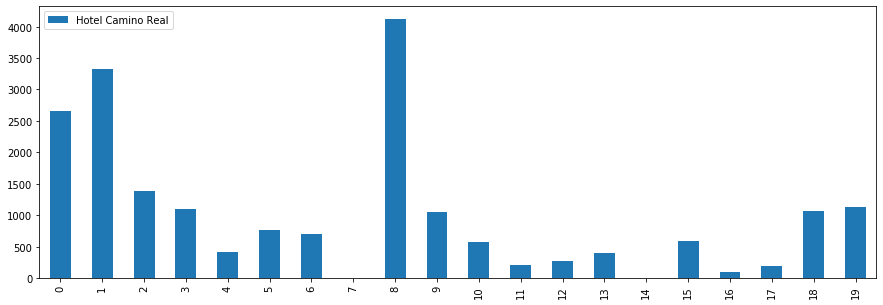

In [31]:
# making matplotlib graph
%matplotlib inline
places_gmaps_df["user_ratings_total"].plot(kind="bar", figsize=(15,5))
plt.legend(labels=places_gmaps_df["name"], loc="upper left")
plt.show

In [32]:
# in the table above i need to split the "type" columns
places_gmaps_df['category'] = places_gmaps_df['types'].apply(lambda x: ','.join(map(str, x)))
places_gmaps_df["types"] = places_gmaps_df["category"].str.split(",", 2, expand=True)[0]
places_gmaps_df["types2"] = places_gmaps_df["category"].str.split(",", 2, expand=True)[1]

In [33]:
# i will count how many types of food services i have. 
print(places_gmaps_df.types.value_counts())
print('\n')
print(places_gmaps_df.types2.value_counts())

restaurant    17
lodging        2
bar            1
Name: types, dtype: int64


food          15
restaurant     2
bar            2
cafe           1
Name: types2, dtype: int64


there is only 1 type of cafe. No one has dessert or bakery clasification. that means that there could be a lot of people looking for a bakery and they cant find it. By hand i know that Circus, Lorca, Pasteleria Fridolin and Piccolo sells desserts. The idea is to make pavlovas cake and that doesnt exist around plaza 24 de sept.

In [34]:
places_gmaps_df.price_level.mean()

2.0

The mean of the price column is 2. The interpretation for this is that all restaurants are in a "moderate" level. That could mean that the mean ticket you get in a restaurant in Bolivia is about 8-12 usd for good meals. I spect that peorple spend 3-4 usd dollars per dessert or sweet cakes. 

In [35]:
# getting distance matrix
#gmaps.distance_matrix(origins=[geocode.latitude, geocode.longitude], destinations=tuple(places_gmaps_df[["geometry.location.lat", "geometry.location.lng"]].values.tolist()))
distance_matrix = gmaps.distance_matrix(origins="-17.78329515, -63.182114510279575", destinations=places_gmaps_df[["geometry.location.lat", "geometry.location.lng"]].values.tolist())
pprint.pprint(distance_matrix)

{'destination_addresses': ['Avenida San Martin & Calle k , Cuarto Anillo, '
                           'Santa Cruz de la Sierra, Bolivia',
                           '9 Oeste 4, Santa Cruz de la Sierra, Bolivia',
                           '24 de septiembre 70, Santa Cruz de la Sierra, '
                           'Bolivia',
                           'Ave Ana Barba 435, Santa Cruz de la Sierra, '
                           'Bolivia',
                           'Andres Manso 340, Santa Cruz de la Sierra, Bolivia',
                           'Sucre 8, Santa Cruz de la Sierra, Bolivia',
                           'Avenida Cristóbal De Mendoza 553, Santa Cruz de la '
                           'Sierra, Bolivia',
                           'MJ Santiestevan 509, Santa Cruz de la Sierra, '
                           'Bolivia',
                           'Los Toborochis 78, Santa Cruz de la Sierra, '
                           'Bolivia',
                           'Ñuflo de Chávez 384, Santa 

In [36]:
#getting distances from plaza 24 de septiembre
places_gmaps_df["distance"] = 0 #assing distance to dataframe. The order is not an issue because the request was made from de dataframe location data
for values, i in zip(distance_matrix["rows"][0]["elements"], range(0,20)):
    places_gmaps_df.loc[[i], ["distance"]] = values["distance"]["value"]

places_gmaps_df.sort_values(by=["rating", "distance"], ascending=False)
places_gmaps_df = places_gmaps_df.loc[slice(None), ["id", "name", "place_id", "rating", "types", "types2", "user_ratings_total", "price_level", "distance","geometry.location.lat", "geometry.location.lng"]]
places_gmaps_df.price_level.fillna(2, inplace=True)

# lets use machine learning method to clasiffy restaurants

I need to classify de venues. First, i am thinking about implementing the kmeans algorithm to classify the locations gotten.

In [37]:
# number or clusters = 2


In [38]:
# geting dummis in places_gmaps_df
#places_gmaps_df.types.str.get_dummies().columns
places_gmaps_df["bar"] = places_gmaps_df.types.str.get_dummies()["bar"]
places_gmaps_df["lodging"] = places_gmaps_df.types.str.get_dummies()["lodging"]
places_gmaps_df["restaurant"] = places_gmaps_df.types.str.get_dummies()["restaurant"]
places_gmaps_df["bar2"] = places_gmaps_df.types2.str.get_dummies()["bar"]
places_gmaps_df["cafe"] = places_gmaps_df.types2.str.get_dummies()["cafe"]
places_gmaps_df["food"] = places_gmaps_df.types2.str.get_dummies()["food"]
places_gmaps_df["restaurant2"] = places_gmaps_df.types2.str.get_dummies()["restaurant"]

for i in places_gmaps_df.index:
    if (places_gmaps_df.bar[i] == 0) and (places_gmaps_df.bar2[i] == 1):
        places_gmaps_df.loc[i, ["bar"]] = places_gmaps_df.bar2[i]
    if (places_gmaps_df.restaurant[i] == 0) and (places_gmaps_df.restaurant2[i] == 1):
        places_gmaps_df.loc[i, ["restaurant"]] = places_gmaps_df.restaurant2[i]

places_gmaps_df.drop(columns=["types", "types2", "bar2", "restaurant2"], inplace=True)

In [39]:
X = places_gmaps_df[["user_ratings_total","price_level","distance","bar","lodging", "restaurant", "cafe", "food"]].values
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 1.51195489,  0.        ,  2.37421139,  2.38047614,  3.        ,
        -4.35889894, -0.22941573, -1.73205081],
       [ 2.13156353,  0.        ,  1.39654034, -0.42008403,  3.        ,
         0.22941573, -0.22941573, -1.73205081],
       [ 0.35144714,  0.        , -1.59746677,  2.38047614, -0.33333333,
         0.22941573, -0.22941573, -1.73205081],
       [ 0.0814552 ,  0.        ,  0.33135623, -0.42008403, -0.33333333,
         0.22941573, -0.22941573,  0.57735027],
       [-0.54272957,  0.        , -0.33780922, -0.42008403, -0.33333333,
         0.22941573, -0.22941573,  0.57735027]])

In [40]:
k = 3
k_means = KMeans(init="k-means++", n_clusters=k, n_init=10).fit(places_gmaps_df[["user_ratings_total","price_level","distance","bar","lodging", "restaurant", "cafe", "food"]])
k_means.labels_[0:10] 

array([2, 2, 1, 0, 1, 1, 0, 0, 2, 1], dtype=int32)

In [41]:
places_gmaps_df.insert(0, "cluster_labels", k_means.labels_)

In [42]:
# creating clusters map
map_clusters = folium.Map(location= [geocode.latitude, geocode.longitude], zoom_start=11)
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, nam, cluster in zip(places_gmaps_df["geometry.location.lat"], places_gmaps_df["geometry.location.lng"], places_gmaps_df["name"], places_gmaps_df["cluster_labels"]):
    label = folium.Popup(str(nam) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters